# Heterogeneous/ Multi-Modal

*Binary Classification of Galaxy Morphologies Using Images Paired with Tabular Metadata.*

![bannerGalaxy](../images/banner_galaxy.png)

Mixed data analysis is one of the areas where deep learning really sets itself apart from traditional statistics and machine learning. Neural networks are an effective way to logically encode and combine any type of data (image, text, time series, audio, tabular spreadsheets, video, etc) all-the-while converging toward the minimization a single *loss* metric. This leads to rich experiments that resemble real-world scenarios; aka man-machine symbiosis. For example, consider combining a doctor's diagnosis notes with electronic medical records and histology imagery.

---

*This is an advanced example put together for a demo that builds upon the documentation of the Low-Level API and the example workflows for binary classification.*

In [2]:
import aiqc

In [ ]:
%capture
aiqc.setup()
aiqc.destroy_db(confirm=True, rebuild=True)

---

## Ingesting Example Galaxy Data

### Tabular Data

In [199]:
from aiqc import datum
df = datum.to_pandas('galaxies.tsv')

Using the built-in structured data about 40 galaxies, we'll derive:

- A binary, categorical label: `morphology`.
- Categorical and numeric metadata features: `clarity`, `angle`.
- A manifest detailing where to find our image files: `url`.

In [200]:
df.head(3)

,morphology,clarity,angle,url
0,bar,0,face,https://raw.githubusercontent.com/aiqc/aiqc/ma...
1,bar,3,angle,https://raw.githubusercontent.com/aiqc/aiqc/ma...
2,bar,3,face,https://raw.githubusercontent.com/aiqc/aiqc/ma...


From a single `Dataset.Tabular` we'll specify a `Label` and `Feature` before encoding them.

In [9]:
dataset_tab = aiqc.Dataset.Tabular.from_pandas(df)

In [12]:
label = dataset_tab.make_label(columns=['morphology'])

In [13]:
from sklearn.preprocessing import *

In [14]:
label.make_labelcoder(sklearn_preprocess=OrdinalEncoder())

<Labelcoder: 1>

In [15]:
feature_tab = dataset_tab.make_feature(exclude_columns=['morphology','url'])

In [16]:
encoderset = feature_tab.make_encoderset()

In [17]:
encoderset.make_featurecoder(
    sklearn_preprocess = StandardScaler(),
    columns = ['clarity']
)


___/ featurecoder_index: 0 \_________


=> Info - System overriding user input to set `sklearn_preprocess.copy=False`.
   This saves memory when concatenating the output of many encoders.

=> The column(s) below matched your filter(s) and were ran through a test-encoding successfully.

['clarity']

=> The remaining column(s) and dtype(s) can be used in downstream Featurecoder(s):
{'angle': 'object'}



<Featurecoder: 1>

In [30]:
encoderset.make_featurecoder(
    sklearn_preprocess = OneHotEncoder(),
    columns = ['angle']
)


___/ featurecoder_index: 1 \_________


=> Info - System overriding user input to set `sklearn_preprocess.sparse=False`.
   This would have generated 'scipy.sparse.csr.csr_matrix', causing Keras training to fail.

=> The column(s) below matched your filter(s) and were ran through a test-encoding successfully.

['angle']

=> Done. All feature column(s) have encoder(s) associated with them.
No more Featurecoders can be added to this Encoderset.



<Featurecoder: 2>

### Image Data

Construct a `Dataset.Image` from that manifest and use it as a 2nd `Feature`.

In [8]:
urls = df['url'].tolist()

In [10]:
dataset_img = aiqc.Dataset.Image.from_urls(urls)

🖼️ Ingesting Images 🖼️: 100%|████████████████████████| 40/40 [00:04<00:00,  8.51it/s]


In [173]:
example_images = aiqc.Dataset.Image.to_pillow(id=dataset_img.id)

**Bar galaxies**

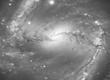

In [189]:
example_images[15]

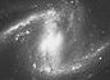

In [218]:
example_images[0]

Although it is easy enough to distinguish between the two types with the naked eye, you start to realize that a *bar* galaxy is almost like a degraded *spiral* galaxy. Like anything else, there is a gray area in whether or not the band of stars/ rectangle of light connecting the two main galactic arms is to be considered a "bar" or more of an oval.

**Spiral galaxies**

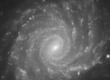

In [192]:
example_images[38]

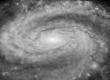

In [193]:
example_images[37]

In [31]:
feature_img = dataset_img.make_feature()

We have only 40 samples, so we'll keep our validation and test *splits* on the smaller size, and definitely forgo cross-validation.

Notice how we pass in both the *tabular* and *image* Features.

In [32]:
splitset = aiqc.Splitset.make(
    feature_ids = [feature_tab.id, feature_img.id]
	, label_id = label.id
    , size_validation = 0.125
	, size_test = 0.175
    , fold_count = None
)

---

## Defining a Model

AIQC makes it easy to compartmentalize both Keras/TensorFlow and PyTorch models. See `Algorithm` in the Low-Level API documentation.

In [33]:
import keras
from keras.models import Sequential, Model
from keras import layers

Hyperparameters are passed in as the `hp**` *kwargs*, which allows you to tweak both the topology and the params alike.

Below we see two towers, feedforward and convolutional, that are eventually concatenated together.

In [35]:
def fn_build(feature_shapes, label_shape, **hp):
    
    # Feed forward tower using the first Feature.
    ff_input = layers.Input(shape=feature_shapes[0][0])    
    ff = layers.Dense(units=hp['ff_neurons'], activation='relu')(ff_input)
    ff = layers.Dropout(0.2)(ff)
    model_ff = Model(ff_input, ff)
        
    # Convolutional tower using the second Feature.
    cnn_input = layers.Input(shape=feature_shapes[1])
    cnn = layers.Conv1D(
        16*hp['cnn_multiply'], kernel_size=3,
        padding='same', activation='relu',
        kernel_initializer=hp['init'])(cnn_input)
    #cnn = layers.MaxPooling1D(pool_size=2)(cnn)
    cnn = layers.BatchNormalization()(cnn)
    cnn = layers.Dropout(hp['dropout'])(cnn)
    
    cnn = layers.Conv1D(
        16*hp['cnn_multiply'], kernel_size=3,
        padding='same', activation='relu',
        kernel_initializer=hp['init'])(cnn)
    #cnn = layers.MaxPooling1D(pool_size=2)(cnn)
    cnn = layers.BatchNormalization()(cnn)
    cnn = layers.Dropout(hp['dropout'])(cnn)
    
    cnn = layers.Conv1D(
        32*hp['cnn_multiply'], kernel_size=3,
        padding='same', activation='relu',
        kernel_initializer=hp['init'])(cnn)
    #cnn = layers.MaxPooling1D(pool_size=2)(cnn)
    cnn = layers.BatchNormalization()(cnn)
    cnn = layers.Dropout(hp['dropout'])(cnn)
    
    if ('4th_cnn' == True):
        cnn = layers.Conv1D(
            32*hp['cnn_multiply'], kernel_size=3,
            padding='same', activation='relu',
            kernel_initializer=hp['init'])(cnn)
        #cnn = layers.MaxPooling1D(pool_size=2)(cnn)
        cnn = layers.BatchNormalization()(cnn)
        cnn = layers.Dropout(hp['dropout'])(cnn)

    # Perform one dense layer on CNN output, so that the tabular data
    # can talk directly to the 
    cnn = layers.Flatten()(cnn)
    cnn = layers.BatchNormalization()(cnn)
    cnn = layers.Activation('relu')(cnn)
    cnn = layers.Dropout(0.2)(cnn)
    model_cnn = Model(cnn_input, cnn)

    concat = layers.concatenate([model_ff.output, model_cnn.output])
    join = layers.Dense(hp['concat_neurons'], activation='relu')(concat)
    join = layers.BatchNormalization()(join)
    join = layers.Activation('relu')(join)
    join = layers.Dropout(0.2)(join)
    
    join = layers.Dense(label_shape[0], activation='sigmoid')(join)
    

    model = Model(inputs=[model_ff.input, model_cnn.input], outputs=join)
    return model

In [108]:
def fn_train(model, loser, optimizer, samples_train, samples_evaluate, **hp):
    model.compile(
        loss = loser
        , optimizer = optimizer
        , metrics = ['accuracy']
    )
    
    # Early stopper.
    metrics_cuttoffs = [
        {"metric":"accuracy", "cutoff":0.90, "above_or_below":"above"},
        {"metric":"val_accuracy", "cutoff":0.80, "above_or_below":"above"}, #5 samples in validation set.
    ]
    cutoffs = aiqc.TrainingCallback.Keras.MetricCutoff(metrics_cuttoffs)
    callbacks=[keras.callbacks.History(), cutoffs]    
        
        
    model.fit(
        x = samples_train["features"]
        , y = samples_train["labels"]
        , validation_data = (
            samples_evaluate["features"]
            , samples_evaluate["labels"]
        )
        , verbose = 0
        , batch_size = hp['batch_size']
        , epochs = hp['epoch_count']
        , callbacks=callbacks
    )
    return model

You can also customize the functions for loss, optimization, and prediction - but we'll just run with the defaults for binary classification analysis.

In [109]:
algorithm = aiqc.Algorithm.make(
    library = "keras"
    , analysis_type = "classification_binary"
    , fn_build = fn_build
    , fn_train = fn_train
    
    , fn_lose = None
    , fn_optimize = None
    , fn_predict = None
)

Define the params that will be passed in as the `hp**` argument in the functions above.

In [110]:
hyperparameters = {
    "epoch_count": [300]
    , "learning_rate": [0.01]
    , "batch_size": [5]
    
    , "ff_neurons": [5]

    , "cnn_multiply": [1.0, 0.5]
    , "dropout": [0.5]
    , "init": ['he_normal']
    , "4th_cnn": [True]
    
    , "concat_neurons": [64]
}

In [111]:
hyperparamset = algorithm.make_hyperparamset(
    hyperparameters = hyperparameters
)

---

## Train Models

`repeat_count` runs the same model/params multiple times to help rule chance out of [or into] these non-deterministic analyses.

In [112]:
queue = algorithm.make_queue(
    splitset_id = splitset.id
    , hyperparamset_id = hyperparamset.id
    , repeat_count = 5
)

In [113]:
import tensorflow as tf
tf.get_logger().setLevel('ERROR');

In [114]:
queue.run_jobs()

🔮 Training Models 🔮:   0%|                                                 | 0/10 [00:00<?, ?it/s]

:: Epoch #115 ::
Congratulations - satisfied early stopping thresholds defined in `MetricCutoff` callback:
[{'above_or_below': 'above', 'cutoff': 0.9, 'metric': 'accuracy'},
 {'above_or_below': 'above', 'cutoff': 0.8, 'metric': 'val_accuracy'}]



🔮 Training Models 🔮:  10%|████                                     | 1/10 [00:12<01:52, 12.53s/it]

:: Epoch #167 ::
Congratulations - satisfied early stopping thresholds defined in `MetricCutoff` callback:
[{'above_or_below': 'above', 'cutoff': 0.9, 'metric': 'accuracy'},
 {'above_or_below': 'above', 'cutoff': 0.8, 'metric': 'val_accuracy'}]



🔮 Training Models 🔮:  20%|████████▏                                | 2/10 [00:28<01:54, 14.26s/it]

:: Epoch #21 ::
Congratulations - satisfied early stopping thresholds defined in `MetricCutoff` callback:
[{'above_or_below': 'above', 'cutoff': 0.9, 'metric': 'accuracy'},
 {'above_or_below': 'above', 'cutoff': 0.8, 'metric': 'val_accuracy'}]



🔮 Training Models 🔮:  30%|████████████▎                            | 3/10 [00:32<01:09,  9.94s/it]

:: Epoch #66 ::
Congratulations - satisfied early stopping thresholds defined in `MetricCutoff` callback:
[{'above_or_below': 'above', 'cutoff': 0.9, 'metric': 'accuracy'},
 {'above_or_below': 'above', 'cutoff': 0.8, 'metric': 'val_accuracy'}]



🔮 Training Models 🔮:  40%|████████████████▍                        | 4/10 [00:41<00:56,  9.35s/it]

:: Epoch #138 ::
Congratulations - satisfied early stopping thresholds defined in `MetricCutoff` callback:
[{'above_or_below': 'above', 'cutoff': 0.9, 'metric': 'accuracy'},
 {'above_or_below': 'above', 'cutoff': 0.8, 'metric': 'val_accuracy'}]



🔮 Training Models 🔮:  50%|████████████████████▌                    | 5/10 [00:55<00:55, 11.02s/it]

:: Epoch #105 ::
Congratulations - satisfied early stopping thresholds defined in `MetricCutoff` callback:
[{'above_or_below': 'above', 'cutoff': 0.9, 'metric': 'accuracy'},
 {'above_or_below': 'above', 'cutoff': 0.8, 'metric': 'val_accuracy'}]



🔮 Training Models 🔮:  60%|████████████████████████▌                | 6/10 [01:06<00:44, 11.14s/it]

:: Epoch #104 ::
Congratulations - satisfied early stopping thresholds defined in `MetricCutoff` callback:
[{'above_or_below': 'above', 'cutoff': 0.9, 'metric': 'accuracy'},
 {'above_or_below': 'above', 'cutoff': 0.8, 'metric': 'val_accuracy'}]



🔮 Training Models 🔮:  70%|████████████████████████████▋            | 7/10 [01:17<00:33, 11.16s/it]

:: Epoch #167 ::
Congratulations - satisfied early stopping thresholds defined in `MetricCutoff` callback:
[{'above_or_below': 'above', 'cutoff': 0.9, 'metric': 'accuracy'},
 {'above_or_below': 'above', 'cutoff': 0.8, 'metric': 'val_accuracy'}]



🔮 Training Models 🔮:  80%|████████████████████████████████▊        | 8/10 [01:33<00:25, 12.66s/it]

:: Epoch #281 ::
Congratulations - satisfied early stopping thresholds defined in `MetricCutoff` callback:
[{'above_or_below': 'above', 'cutoff': 0.9, 'metric': 'accuracy'},
 {'above_or_below': 'above', 'cutoff': 0.8, 'metric': 'val_accuracy'}]



🔮 Training Models 🔮:  90%|████████████████████████████████████▉    | 9/10 [01:59<00:16, 16.64s/it]

:: Epoch #95 ::
Congratulations - satisfied early stopping thresholds defined in `MetricCutoff` callback:
[{'above_or_below': 'above', 'cutoff': 0.9, 'metric': 'accuracy'},
 {'above_or_below': 'above', 'cutoff': 0.8, 'metric': 'val_accuracy'}]



🔮 Training Models 🔮: 100%|████████████████████████████████████████| 10/10 [02:09<00:00, 12.90s/it]


---

## Interpret Results

The *boomerang* chart shows how each model performed across all of its splits [and or folds].

In [ ]:
queue.plot_performance(
    max_loss = 3.0, min_accuracy = 0.70
)

![galaxyBoomerang](../images/galaxy_boomerang.png)

Let's dig into that green model with precise loss.

In [132]:
predictor = aiqc.Predictor.get_by_id(26)

In [133]:
predictor.get_hyperparameters(as_pandas=True)

,param,value
0,epoch_count,300
1,learning_rate,0.01
2,batch_size,5
3,ff_neurons,5
4,cnn_multiply,1.0
5,dropout,0.5
6,init,he_normal
7,4th_cnn,True
8,concat_neurons,64


Not exactly the smoothest curve, and it seems like we could have learned more with a bit of patience, but, then again, it always seems that way.

In [ ]:
predictor.plot_learning_curve(loss_skip_15pct=True)

![galaxyLearn](../images/galaxy_learn.png)

The charts below show how it performed when running predictions against each split in the dataset.

In [140]:
prediction = predictor.predictions[0]

In [ ]:
prediction.plot_roc_curve()

![galaxyRoc](../images/galaxy_roc.png)

Interestingly enough, the model is performing poorly on the *training* split. I guess that's what you get when you set `dropout=0.5`. You can tell that it hasn't learned all of the spiral patterns yet.

In [ ]:
prediction.plot_confusion_matrix()

![galaxyConfusion](../images/galaxy_confusion.png)

In [ ]:
prediction.plot_precision_recall()

![galaxyPr](../images/galaxy_pr.png)

We have all of the metrics for every run precalculated and at our disposal.

In [161]:
queue.metrics_aggregate_to_pandas()

,hyperparamcombo_id,job_id,repeat_index,predictor_id,metric,maximum,minimum,pstdev,median,mean
0,8,8,0,22,accuracy,1.000000,0.571429,0.175093,0.800000,0.790476
1,8,8,0,22,f1,1.000000,0.571429,0.175093,0.800000,0.790476
2,8,8,0,22,loss,0.657118,0.433796,0.101170,0.638489,0.576468
3,8,8,0,22,precision,1.000000,0.500000,0.235702,1.000000,0.833333
4,8,8,0,22,recall,1.000000,0.666667,0.157135,0.666667,0.777778
5,8,8,0,22,roc_auc,1.000000,0.666667,0.136083,0.833333,0.833333
6,9,9,0,23,accuracy,0.800000,0.571429,0.098111,0.750000,0.707143
7,9,9,0,23,f1,0.857143,0.666667,0.079808,0.800000,0.774603
8,9,9,0,23,loss,0.626964,0.515694,0.050871,0.619902,0.587520
9,9,9,0,23,precision,0.750000,0.500000,0.103935,0.666667,0.638889


In [162]:
queue.metrics_to_pandas()

,hyperparamcombo_id,job_id,repeat_index,predictor_id,split,accuracy,f1,loss,precision,recall,roc_auc
29,9,9,4,31,train,0.714286,0.764706,0.473485,0.650000,0.928571,0.933673
28,9,9,4,31,validation,0.800000,0.857143,0.620068,0.750000,1.000000,0.833333
27,9,9,4,31,test,0.714286,0.750000,0.722628,0.600000,1.000000,0.666667
26,8,8,4,30,train,0.750000,0.758621,0.547876,0.733333,0.785714,0.811224
25,8,8,4,30,validation,0.800000,0.800000,3.459070,1.000000,0.666667,0.666667
24,8,8,4,30,test,0.571429,0.571429,0.636163,0.500000,0.666667,0.666667
23,9,9,3,29,train,0.821429,0.848485,0.299485,0.736842,1.000000,1.000000
22,9,9,3,29,validation,0.800000,0.857143,0.845627,0.750000,1.000000,0.666667
21,9,9,3,29,test,0.714286,0.750000,0.975309,0.600000,1.000000,0.833333
20,8,8,3,28,train,0.892857,0.896552,0.412229,0.866667,0.928571,0.969388


We can also inspect the actual predictions for each split, which have been automatically `inverse_transform`'ed back from their encoded values.

In [9]:
predictor.predictions[0].predictions

{'test': array(['bar', 'bar', 'spiral', 'spiral', 'bar', 'spiral', 'bar'],
       dtype=object),
 'validation': array(['bar', 'spiral', 'bar', 'spiral', 'bar'], dtype=object),
 'train': array(['spiral', 'bar', 'spiral', 'spiral', 'spiral', 'spiral', 'bar',
        'bar', 'spiral', 'bar', 'spiral', 'bar', 'bar', 'bar', 'spiral',
        'bar', 'bar', 'bar', 'spiral', 'bar', 'bar', 'bar', 'bar',
        'spiral', 'bar', 'bar', 'bar', 'bar'], dtype=object)}

Let's dig into our recorded experiment to pull out the samples within the training set that were misclassified by comparing them to their actual labels.

In [14]:
train_predicted = predictor.predictions[0].predictions['train']

In [12]:
train_samples = predictor.job.queue.splitset.samples['train']

In [19]:
train_actual = predictor.job.queue.splitset.label.to_numpy(samples=train_samples).flatten()

In [21]:
comparison = train_predicted == train_actual

In [34]:
train_misclassifications = np.argwhere(comparison==False).flatten().tolist()

In [35]:
train_samples_miss = [train_samples[miss] for miss in train_misclassifications]

In [48]:
img_miss = aiqc.Dataset.Image.to_pillow(id=2, samples=train_samples_miss)

Here is an example of a spiral that was missclassified as a bar.

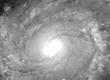

In [62]:
img_miss[4]